In [36]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [37]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph 
from langgraph.graph import START, END

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_teddynote.tools import GoogleNews

from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import pretty_print_messages
from langchain_teddynote.messages import display_message_tree
from langchain_core.runnables import RunnableConfig

from langchain_openai import ChatOpenAI

In [38]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, 'dummy']

In [39]:
######### 2. 도구 정의 및 바인딩 #########

@tool
def search_keyword(query: str) -> List[Dict[str, str]]:     # 키워드로 뉴스 검색하는 도구     
    """Look up news by keyword"""

    news_tool = GoogleNews()        
    return news_tool.search_by_keyword(query, k=1)


tools = [search_keyword]

In [40]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

llm_with_tools = llm.bind_tools(tools)

In [41]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state['messages'])

    print('=================================================================================')
    print(f'chatbot() 실행\n')
    print(f"[1] state[messages]: \n{state['messages']}\n")
    # print(f'[2] chatbot answer: \n', answer , "\n")
    print(f'[2] chatbot answer: \n', answer.content)
    print(f'[3] answer.additional_kwargs: \n', answer.additional_kwargs)
    print('=================================================================================')
    
    return {
        'messages': [answer], 
        'dummy_data': '[chatbot] 호출, dummy_data'
    }

In [42]:
# 상태 그래프 생성
graph_builder = StateGraph(State)

In [43]:
# chatbot 노드 추가
graph_builder.add_node('chatbot', chatbot)

In [44]:
# 도구 노드 생성
tool_node = ToolNode(tools=[search_keyword])

In [45]:
# 도구 노드 추가
graph_builder.add_node('tools', tool_node)

In [46]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [47]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [48]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [49]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [50]:
######### 6. 메모리 생성 #######

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [52]:
######### 7. 그래프 컴파일 #######

graph = graph_builder.compile(checkpointer=memory)

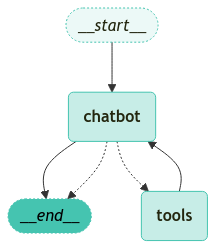

In [53]:
######### 8. 그래프 #######

visualize_graph(graph)

In [54]:
from langchain.schema import HumanMessage, AIMessage
from langchain_core.messages import ToolMessage

question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'},
    tags=['data-tag']
)

i = 1

for event in graph.stream(input=input, config=config):      # 모드에 따라 event가 딕셔너리 또는 리스트. 기본 모드는 evenv가 딕셔서리 이다.
    print(f'({i})')
    print('=== 반복문 바같 === 시작')

    for key, value in event.items():
        print('=== 반복문 === 시작')
        print(f'\n[노드 이름]: {key}\n')                    # key 에는 노드의 이름
        # print(f"\n해당 노드의 값[value]: \n{value['messages'][-1]}")            

        if value['messages'][-1] is not None:
            if isinstance(value['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"해당 노드의 값 [value][messages][-1]: \n{value['messages'][-1]}")        # value에는 해당 노드의 값. state 이다
                print('==================== END HumanMessage ====================')
                print() 
            elif isinstance(value['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                print(f"해당 노드의 값 [value]: \n{value['messages'][-1]}")        # value에는 해당 노드의 값
                print('==================== END AIMessage ====================')     
                print()       
            elif isinstance(value['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')
                print(f"해당 노드의 값 [value]: \n{value['messages'][-1]}")        # value에는 해당 노드의 값
                print(f'Tool Calls:')
                print(f"\t name: {value['messages'][-1].name}")
                print(f"\t tool_call_id: {value['messages'][-1].tool_call_id}")
                print('==================== END ToolMessage ====================')     
                print()       
        else:
            print(f"해당 노드의 값 [value]: 없음")
            print()

        print('=== 반복문 === 끝')
    print('=== 반복문 바같 === 끝\n\n')
    
    i=i+1

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='a20b7907-5a83-4792-be27-7f79e87524b9')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_Lol9XyFoDvsMvtdlGPCXH2tU', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}
(1)
=== 반복문 바같 === 시작
=== 반복문 === 시작

[노드 이름]: chatbot

==================== AIMessage ========================
해당 노드의 값 [value]: 
content='' additional_kwargs={'tool_calls': [{'id': 'call_Lol9XyFoDvsMvtdlGPCXH2tU', 'function': {'arguments': '{"query":"2024 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_det

In [55]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '2'},
    tags=['data-tag']
)

In [56]:
for event in graph.stream(input=input, config=config):      # 모드에 따라 event가 딕셔너리 또는 리스트. 기본 모드는 evenv가 딕셔서리 이다.
    for key, value in event.items():
        print(f'\n{key}\n')                                 # key 에는 노드의 이름

        if 'messages' in value:                             # value에는 해당 노드의 값
            message = value['messages']
            value['messages'][-1].pretty_print()

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='d3aa1bcd-e456-4aa1-92c7-0648831c3d38')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_BgU3UEHiMwLjR5etUrs9qiZj', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}

chatbot

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_BgU3UEHiMwLjR5etUrs9qiZj)
 Call ID: call_BgU3UEHiMwLjR5etUrs9qiZj
  Args:
    query: 2024 Nobel Prize in Literature

tools

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiigFBVV95cUxNblM5bndNclA5Q0J2RW9NZ09XRTdyZ0ZhZ3diZUpodEU2WlhaVzFVZ3doZjI1ZEF6dGF5SnVQUVdCdF9tNUJnWjZ1LV8xTlNqT01xZmFaQ2NNNVdkM1RtR0ZCb0tDUzVZQk5oLVp1d1dpX2x2V2g4R3dKV0V3NV

In [57]:
list(graph.channels.keys())

['messages',
 'dummy_data',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

In [58]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '9'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, output_keys=['dummy_data']):
    for key, value in event.items():
        print(f"(1) [key]: {key}")
        print(f"(2) [value]: {value}")

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='6d5ce21b-5cc9-4263-9bbe-269f397b2d44')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_Fwgl89WGsTgNbDioLIqBbYJn', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}
(1) [key]: chatbot
(2) [value]: {'dummy_data': '[chatbot] 호출, dummy_data'}
(1) [key]: tools
(2) [value]: None
chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='6d5ce21b-5cc9-4263-9bbe-269f397b2d44'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Fwgl89WGsTgNbDioLIqBbYJn', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens

In [59]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '11'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, output_keys=['dummy_data', 'messages']):
    for key, value in event.items():
        print()
        print('=' * 100)
        print(f"(1) [key]: {key}")

        if value:
            print(f"(2) [value]: {value}")
            print(f"(2-1) [value.keys()]: {value.keys()}")

            if 'dummy_data' in value:
                print(f"(3) [value[dummy_data]]: {value['dummy_data']}")
            else:
                print(f"(3) [value[dummy_data]]: 없음")
            
            if 'messages' in value:
                print(f"(4) [value[messages]]:")
                print(f" {value['messages']}")
            else:
                print(f"(4) [value[messages]]: 없음")

        else:
            print(f"(2) [value]: 없음")
        print('=' * 100)

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='4e6f704a-10dd-4f30-8a35-e883d9e79aa3')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_USBUjwGVjeNsaSWExF4A0MHl', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}

(1) [key]: chatbot
(2) [value]: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_USBUjwGVjeNsaSWExF4A0MHl', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 57, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached

In [60]:
question = '대구 중앙떡볶이 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '12'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, stream_mode='values'): 
    for key, value in event.items():            # values 모드이면 key에는 state의 key 값(messages, dummy_data), value에는 state의 key 에 해당하는 값
        print()
        print('=' * 100)
        print(f"[key]: {key}")

        if key=='messages':
            print(f"[messages] 개수 : {len(value)}")
            print(f"[messages] 메시지: ")
            print(f"{value}")
        else:
            print(f"[messages]: 없음")
            
    print('==='*9, ' 단계 ', "==="*9)



[key]: messages
[messages] 개수 : 1
[messages] 메시지: 
[HumanMessage(content='대구 중앙떡볶이 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='76c88ac7-fbd4-404b-b787-c3bc5f877538')]

[key]: dummy_data
[messages]: 없음
===========================  단계  ===========================
chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='대구 중앙떡볶이 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='76c88ac7-fbd4-404b-b787-c3bc5f877538')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_OeoOAwFZ96735CGXGAu1RkY5', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}

[key]: messages
[messages] 개수 : 2
[messages] 메시지: 
[HumanMessage(content='대구 중앙떡볶이 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='76c88ac7-fbd4-404b-b787-c3bc5f877538'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OeoOAwFZ96735CGXGAu1RkY5', 'function': {'arguments': '{"quer

In [61]:
question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '19'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, stream_mode='updates'):   # 각 단계에 대한 업데이트 된 State만 보낸다.
    for key, value in event.items():            # updates 모드이면 key에는 업데이트 된 출력 노드의 이름, value에는 노드의 해당하는 업데이트된 State 값이 딕셔너리
        print()
        print('=' * 100)
        print(f"[key]: {key}")

        if key=='messages':
            print(f"[messages] 개수 : {len(value)}")
            print(f"[messages] 메시지: ")
            print(f"{value}")
        else:
            print(f"[messages]: 없음")
            
    print('==='*9, ' 단계 ', "==="*9)


chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='0891b671-018b-4d64-a694-b28f3ac900d3')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_XEB0qbEflho0atsghR3sljMC', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}

[key]: chatbot
[messages]: 없음
===========================  단계  ===========================

[key]: tools
[messages]: 없음
===========================  단계  ===========================
chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='0891b671-018b-4d64-a694-b28f3ac900d3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XEB0qbEflho0atsghR3sljMC', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}],

In [62]:
question = '대구 중앙떡볶이에 대해서 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '21'},
    tags=['data-tag']
)

for event in graph.stream(input=input, config=config, interrupt_before=["tools"], output_keys=['dummy_data', 'messages']):
    for key, value in event.items():
        print()
        print('=' * 100)
        print(f"(1) [key]: {key}")

        if value:
            print(f"(2) [value]: {value}")
            print(f"(2-1) [value.keys()]: {value.keys()}")

            if 'dummy_data' in value:
                print(f"(3) [value[dummy_data]]: {value['dummy_data']}")
            else:
                print(f"(3) [value[dummy_data]]: 없음")
            
            if 'messages' in value:
                print(f"(4) [value[messages]]:")
                print(f" {value['messages']}")
            else:
                print(f"(4) [value[messages]]: 없음")

        else:
            print(f"(2) [value]: 없음")
        print('=' * 100)

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요.', additional_kwargs={}, response_metadata={}, id='561e8e89-0044-4f23-b13e-9bdc5137a7df')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_Rt0s8lLaxrCQkrbaYH6Q0MZJ', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}

(1) [key]: chatbot
(2) [value]: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Rt0s8lLaxrCQkrbaYH6Q0MZJ', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 55, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-

In [63]:
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,                 
    configurable={"thread_id": "22"},  
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",
    interrupt_after=["tools"],  # tools 실행 후 interrupt
):
    for value in event.values():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        if isinstance(value, dict):
            # value 는 노드의 출력값
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='1d375a48-06eb-4ddb-ba82-d80d012db3fe')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_Kdy1ELq7XbyI9ZsM9kZQAR8t', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}

[__interrupt__]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Kdy1ELq7XbyI9ZsM9kZQAR8t', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 57, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 